# Traffy Fondue

เป็นแอปพลิเคชั่นสำหรับรับแจ้งปัญหา ข้อเสนอแนะจากผู้แจ้ง และ ระบบสนับสนุนการบริหารจัดการปัญหาให้มีประสิทธิภาพสูงขึ้น โดยผู้แจ้งไม่จำเป็นต้องรู้จักกับเจ้าหน้าที่ หรือทราบว่าใครเป็นผู้รับผิดชอบปัญหามาก่อน ก็สามารถแจ้งปัญหาได้ ระบบออกแบบมาให้ง่ายต่อการใช้งาน เพียงแค่ผู้แจ้งทำการถ่ายรูปและระบุประเภทของปัญหา ระบบจะทำการแจ้งปัญหาดังกล่าวไปยังเจ้าหน้าที่และทีมงานที่รับผิดชอบทันที ในด้านของเจ้าหน้าที่ ระบบจะช่วยคัดแยกประเภทของปัญหาและแจ้งปัญหาต่อเจ้าหน้าที่ผู้ที่มีหน้าที่ดูแลและรับผิดชอบโดยตรง ระบบสามารถให้ข้อมูลความก้าวหน้าในการดำเนินการและติดตามสถานะของปัญหาได้ผ่านโทรศัพท์มือถือ ระบบนี้ช่วยให้ผู้แจ้งมีส่วนร่วมในการดูแลสภาพแวดล้อมของชุมชน(คอนโดมิเนียม, นิคมอุตสาหกรรม, หมู่บ้าน) ของตนเอง และยังเปิดโอกาสให้ผู้แจ้งสามารถให้กำลังใจ ติชมการปฏิบัติงานของเจ้าหน้าที่ได้อีกด้วย ผู้แจ้งและเจ้าหน้าที่สามารถสื่อสารและช่วยกันแก้ไขปัญหาชุมชนร่วมกัน ซึ่งทำให้เกิดความหวงแหน ดูแล รักษา ให้ชุมชน(คอนโดมิเนียม, นิคมอุตสาหกรรม, หมู่บ้าน) มีความน่าอยู่ยิ่งขึ้น

Image classification

10 classes of cases reported from Traffy Fondue
sanitary(ความสะอาด), sewer (ท่อระบายน้ำ), stray (สัตว์จรจัด), canal (คลอง), light (แสงสว่าง), flooding (น้ำท้วม), electric (สายไฟ), traffic (จราจร), road (ถนน), sidewalk (ทางเท้า)

Dataset period: until 2023-02-18

Train 13,274 images, Test 4,648 images

*Please note that I ran this notebook on Kaggle

# Install Library

In [ ]:
!pip install wandb torchsummaryX


# Import Libraries

In [ ]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from IPython.display import display
from torchsummaryX import summary
from torch.optim import lr_scheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

from torch.nn import Embedding, Dropout, GRU, LSTM, Linear, CrossEntropyLoss 


# Setup

## Using wandb to monitor performance while training

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

True

## Using GPU P 100 in Kaggle

In [ ]:
!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5d5656e8-30cf-0415-14cf-2017e1b07bee)


In [ ]:
device = torch.device("cuda:0")
print(f"Using {device} device")

Using cuda:0 device


Assign index to labels

In [ ]:
classes = ['canal', 'electric', 'flooding', 'light', 'road', 'sanitary', 'sewer', 'sidewalk', 'stray', 'traffic']
classes_idx = list(range(len(classes)))
classes_idx = dict(zip(classes, classes_idx))
classes_idx

{'canal': 0,
 'electric': 1,
 'flooding': 2,
 'light': 3,
 'road': 4,
 'sanitary': 5,
 'sewer': 6,
 'sidewalk': 7,
 'stray': 8,
 'traffic': 9}

## Prepare Image Augmentation

In [ ]:
transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4303, 0.4301, 0.4139], std=[0.2186, 0.2140, 0.2205]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4303, 0.4301, 0.4139], std=[0.2186, 0.2140, 0.2205])
    ])


## Generate filename.csv

In [ ]:
path = '/kaggle/input/cleaned-train4/train'
def gen_filename():
    classes = os.listdir(path)
    d = {}
    for c in classes:
        if c == '.DS_Store':
            continue
        images = os.listdir(path+'/' + c)
        for image in images:
            if image == '.DS_Store': continue
            d[image] = c

    df = pd.DataFrame(d.items(), columns=['filename', 'class'])
    df.to_csv('filenames.csv', index=False)


gen_filename()


In [ ]:
df = pd.read_csv('/kaggle/working/filenames.csv')
df

,filename,class
0,train_flooding_img_130.jpg,flooding
1,train_flooding_img_839.jpg,flooding
2,train_flooding_img_1969.jpg,flooding
3,train_flooding_img_1381.jpg,flooding
4,train_flooding_img_1402.jpg,flooding
...,...,...
7270,train_light_img_729.jpg,light
7271,train_light_img_601.jpg,light
7272,train_light_img_645.jpg,light
7273,train_light_img_753.jpg,light


In [ ]:
df['class'].value_counts()

flooding    1341
road        1331
electric     941
light        790
sidewalk     746
traffic      465
sanitary     450
canal        436
sewer        429
stray        346
Name: class, dtype: int64

## Find the mean and standard deviation to Normalize a tensor image which is used in image augmentation part above

In [ ]:
# img_dir = '/kaggle/input/cleaned-train2/train'
# means = []
# stds = []
# to_tensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# for i in range(len(df)):
#     os.path.join(img_dir, df.iloc[i,1].strip(), df.iloc[i,0].strip())
#     img = Image.open(os.path.join(img_dir, df.iloc[i,1].strip(), df.iloc[i,0].strip())).convert('RGB')
#     tensor = to_tensor(img)
#     means.append(tensor.mean(dim=(1,2)))
#     stds.append(tensor.std(dim=(1,2)))
    
# mean = torch.stack(means, dim=0).mean(dim=0)
# std = torch.stack(stds, dim=0).mean(dim=0)
# print(mean, std)

tensor([0.4303, 0.4301, 0.4139]) tensor([0.2186, 0.2141, 0.2205])


# Split the dataset into train set, validation set, and test set with ratio 80:10:10 respectively

Applied stratification and random state = 2022

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=2022)
test_data, val_data = train_test_split(test_data, test_size=0.5, stratify=test_data['class'], random_state=2022)

# Preprocessing data for pytorch

In [ ]:
class TraffyFondueDataset(Dataset):
    
    def __init__(self, 
                 data, 
                 transforms=None):
        
        super().__init__()
        label_image = classes
        self.input_dataset = list()
        for i in range(len(data)):
            img_dir = path
            
            input = [os.path.join(img_dir, data.iloc[i,1].strip(), data.iloc[i,0].strip()), classes_idx[data.iloc[i,1].strip()]] # [image_path, label_num]
            self.input_dataset.append(input)
        
        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx): 
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y

trainset = TraffyFondueDataset(train_data, transform_train)
valset = TraffyFondueDataset(val_data,transform)
testset = TraffyFondueDataset(test_data,transform)
allset = TraffyFondueDataset(df, transform_train)


# Prepare class weights to be applied while training the model

In [ ]:
unique_values, counts = np.unique(df['class'], return_counts=True)
counts_lis = []
label_lis = []
for val, count in zip(unique_values, counts):
    counts_lis.append(count)
    label_lis.append(val)
counts_lis = np.array(counts_lis)

In [ ]:
counts_lis

array([ 436,  941, 1341,  790, 1331,  450,  429,  746,  346,  465])

In [ ]:
def get_weights_inverse_num_of_samples (no_of_classes, samples_per_cls, power = 1) :
    weights_for_samples = 1.0 / np.array (np.power (samples_per_cls, power))
    weights_for_samples = weights_for_samples / np.sum(weights_for_samples) * no_of_classes
    return weights_for_samples

In [ ]:
num_classes=10
class_weights = get_weights_inverse_num_of_samples(10,  counts_lis)
class_weights.shape

(10,)

In [ ]:
summary_stats = {
    'mean': np.mean(class_weights, axis=0),
    'std': np.std(class_weights, axis=0),
    'min': np.min(class_weights, axis=0),
    'max': np.max(class_weights, axis=0),
}
summary_stats

{'mean': 1.0,
 'std': 0.4219148150537325,
 'min': 0.4372769113599797,
 'max': 1.6947639830454706}

In [ ]:
class_weights = torch.Tensor(class_weights).to(device)


# Prepare Dataloader for pytorch

In [ ]:
BATCH_SIZE = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
allloader = torch.utils.data.DataLoader(allset, batch_size=BATCH_SIZE, shuffle=True)

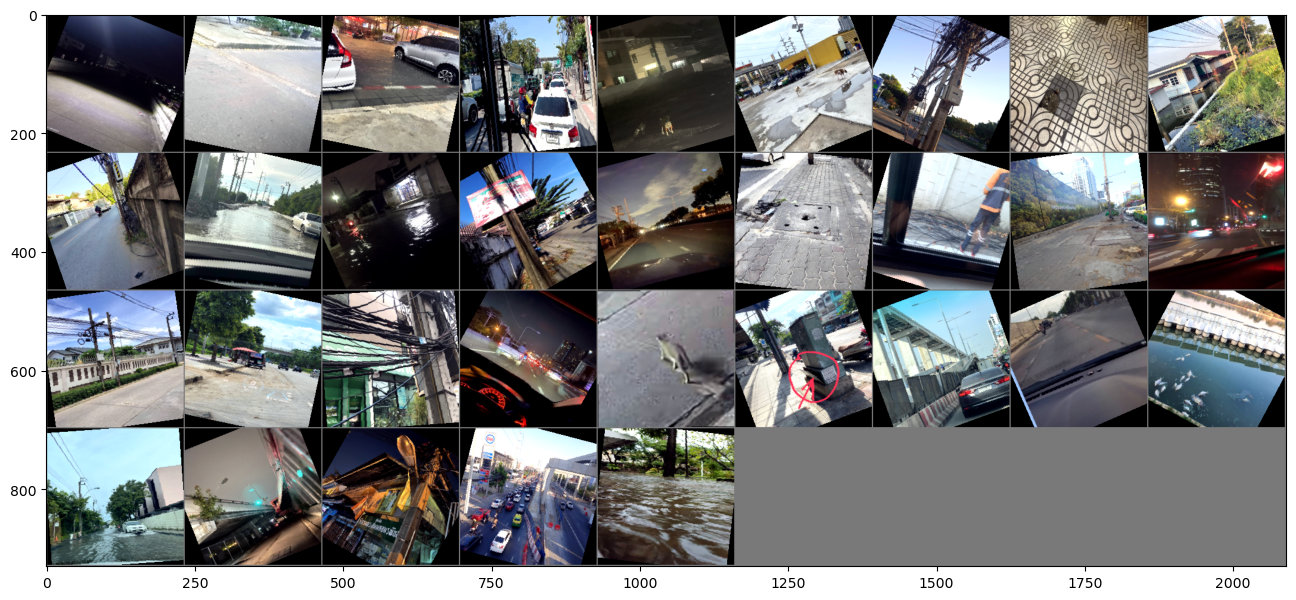

In [ ]:
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(allloader)
images, labels = next(dataiter)

nrow = 9
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [ ]:
for i in range(BATCH_SIZE//nrow + 1 if BATCH_SIZE % nrow else 0):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(BATCH_SIZE - i*nrow, nrow))))

3   4   2   9   8   8   1   7   0  
1   2   2   5   3   6   1   7   9  
1   4   1   9   8   7   9   4   0  
2   3   3   9   2  


# Initialized the model and hyperparameters used for the training process.

In [ ]:
num_classes = 10
model_ft = torchvision.models.efficientnet_b3(weights=True)
    
model_ft.classifier[-1] = nn.Sequential(
    nn.Linear(in_features=model_ft.classifier[-1].in_features, out_features=num_classes),
    nn.Softmax(dim=1)
        )

model = model_ft.to(device)

In [ ]:
summary(model, torch.zeros((128, 3, 224, 224), dtype = torch.float).to(device))


/opt/conda/lib/python3.7/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                                         Kernel Shape  \
Layer                                                                   
0_features.0.Conv2d_0                                   [3, 40, 3, 3]   
1_features.0.BatchNorm2d_1                                       [40]   
2_features.0.SiLU_2                                                 -   
3_features.1.0.block.0.Conv2d_0                         [1, 40, 3, 3]   
4_features.1.0.block.0.BatchNorm2d_1                             [40]   
5_features.1.0.block.0.SiLU_2                                       -   
6_features.1.0.block.1.AdaptiveAvgPool2d_avgpool                    -   
7_features.1.0.block.1.Conv2d_fc1                      [40, 10, 1, 1]   
8_features.1.0.block.1.SiLU_activation                              -   
9_features.1.0.block.1.Conv2d_fc2                      [10, 40, 1, 1]   
10_features.1.0.block.1.Sigmoid_scale_activation                    -   
11_features.1.0.block.2.Conv2d_0                   

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_features.0.Conv2d_0,"[3, 40, 3, 3]","[128, 40, 112, 112]",1080.0,13547520.0
1_features.0.BatchNorm2d_1,[40],"[128, 40, 112, 112]",80.0,40.0
2_features.0.SiLU_2,-,"[128, 40, 112, 112]",NaN,NaN
3_features.1.0.block.0.Conv2d_0,"[1, 40, 3, 3]","[128, 40, 112, 112]",360.0,4515840.0
4_features.1.0.block.0.BatchNorm2d_1,[40],"[128, 40, 112, 112]",80.0,40.0
...,...,...,...,...
356_features.8.SiLU_2,-,"[128, 1536, 7, 7]",NaN,NaN
357_avgpool,-,"[128, 1536, 1, 1]",NaN,NaN
358_classifier.Dropout_0,-,"[128, 1536]",NaN,NaN


In [ ]:
# all augmented dataV2 except vertical flip, random crop, and colorjitter, seed = 2022
# BATCH_SIZE = 32
NUM_EPOCHS = 20
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

config = {
    'architecture': 'traffyfondue',
    'epochs': NUM_EPOCHS
}
run = wandb.init(
    project = 'traffyfondue',
    config = config,
)
wandb.watch(model, log='all')

n_iter,▁▃▅▆█
train_loss,▁▂▅▂█
n_iter,4
train_loss,2.30823


[]

# Training loop

In [ ]:
history_train = {'loss':np.zeros(NUM_EPOCHS), 'acc':np.zeros(NUM_EPOCHS), 'macro_f1-score':np.zeros(NUM_EPOCHS)}
history_val = {'loss':np.zeros(NUM_EPOCHS), 'acc':np.zeros(NUM_EPOCHS), 'macro_f1-score':np.zeros(NUM_EPOCHS)}
min_val_loss = 1e10
best_f1 = -1
PATH = './best_model.pth'
idx = 0

for epoch in range(NUM_EPOCHS):  
    
    print(f'epoch {epoch + 1} \nTraining ...')
    model.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for inputs, labels in tqdm(trainloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            wandb.log({
                'train_loss': loss,
                'n_iter' : idx
            })
            idx += 1
    
            training_loss += loss.item()
            n+=1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    support = report["macro avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%,  Macro f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['macro_f1-score'][epoch] = f1

    print('validating ...')
    model.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    support = report["macro avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, Macro f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['macro_f1-score'][epoch] = f1
    
    wandb.log({
        'val_macro_f1' : f1,
        'val_loss': validation_loss,
    })
    
    if validation_loss < min_val_loss:
        torch.save(model.state_dict(), PATH)
        min_val_loss = validation_loss 
    
print('Finished Training')

epoch 1 
Training ...


100%|██████████| 182/182 [04:56<00:00,  1.63s/it]


training loss: 2.113, acc: 44.48%,  Macro f1-score: 39.37%, support: 5820
validating ...


100%|██████████| 23/23 [00:31<00:00,  1.38s/it]


validation loss: 1.801, acc: 69.78%, Macro f1-score: 68.19%, support: 728
epoch 2 
Training ...


100%|██████████| 182/182 [04:52<00:00,  1.61s/it]


training loss: 1.707, acc: 76.27%,  Macro f1-score: 75.21%, support: 5820
validating ...


100%|██████████| 23/23 [00:31<00:00,  1.38s/it]


validation loss: 1.646, acc: 81.18%, Macro f1-score: 80.48%, support: 728
epoch 3 
Training ...


100%|██████████| 182/182 [04:51<00:00,  1.60s/it]


training loss: 1.628, acc: 83.01%,  Macro f1-score: 82.29%, support: 5820
validating ...


100%|██████████| 23/23 [00:31<00:00,  1.36s/it]


validation loss: 1.613, acc: 83.79%, Macro f1-score: 83.41%, support: 728
epoch 4 
Training ...


100%|██████████| 182/182 [04:51<00:00,  1.60s/it]


training loss: 1.602, acc: 85.74%,  Macro f1-score: 85.08%, support: 5820
validating ...


100%|██████████| 23/23 [00:30<00:00,  1.34s/it]


validation loss: 1.608, acc: 84.48%, Macro f1-score: 83.77%, support: 728
epoch 5 
Training ...


100%|██████████| 182/182 [04:50<00:00,  1.59s/it]


training loss: 1.585, acc: 86.99%,  Macro f1-score: 86.74%, support: 5820
validating ...


100%|██████████| 23/23 [00:31<00:00,  1.36s/it]


validation loss: 1.605, acc: 86.26%, Macro f1-score: 85.45%, support: 728
epoch 6 
Training ...


100%|██████████| 182/182 [05:02<00:00,  1.66s/it]


training loss: 1.568, acc: 89.18%,  Macro f1-score: 88.89%, support: 5820
validating ...


100%|██████████| 23/23 [00:31<00:00,  1.37s/it]


validation loss: 1.605, acc: 85.71%, Macro f1-score: 84.93%, support: 728
epoch 7 
Training ...


100%|██████████| 182/182 [05:11<00:00,  1.71s/it]


training loss: 1.56, acc: 89.57%,  Macro f1-score: 89.51%, support: 5820
validating ...


100%|██████████| 23/23 [00:31<00:00,  1.39s/it]


validation loss: 1.594, acc: 86.68%, Macro f1-score: 86.24%, support: 728
epoch 8 
Training ...


100%|██████████| 182/182 [05:08<00:00,  1.70s/it]


training loss: 1.544, acc: 90.55%,  Macro f1-score: 90.67%, support: 5820
validating ...


100%|██████████| 23/23 [00:31<00:00,  1.37s/it]


validation loss: 1.592, acc: 87.23%, Macro f1-score: 86.91%, support: 728
epoch 9 
Training ...


100%|██████████| 182/182 [05:18<00:00,  1.75s/it]


training loss: 1.534, acc: 92.35%,  Macro f1-score: 92.34%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


validation loss: 1.583, acc: 87.64%, Macro f1-score: 87.32%, support: 728
epoch 10 
Training ...


100%|██████████| 182/182 [05:18<00:00,  1.75s/it]


training loss: 1.531, acc: 92.25%,  Macro f1-score: 92.32%, support: 5820
validating ...


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


validation loss: 1.578, acc: 88.05%, Macro f1-score: 88.0%, support: 728
epoch 11 
Training ...


100%|██████████| 182/182 [05:15<00:00,  1.73s/it]


training loss: 1.526, acc: 92.9%,  Macro f1-score: 93.13%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.41s/it]


validation loss: 1.583, acc: 87.09%, Macro f1-score: 86.67%, support: 728
epoch 12 
Training ...


100%|██████████| 182/182 [05:15<00:00,  1.73s/it]


training loss: 1.521, acc: 93.44%,  Macro f1-score: 93.67%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.41s/it]


validation loss: 1.583, acc: 86.95%, Macro f1-score: 86.55%, support: 728
epoch 13 
Training ...


100%|██████████| 182/182 [05:14<00:00,  1.73s/it]


training loss: 1.521, acc: 93.32%,  Macro f1-score: 93.56%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.42s/it]


validation loss: 1.582, acc: 87.77%, Macro f1-score: 87.38%, support: 728
epoch 14 
Training ...


100%|██████████| 182/182 [05:16<00:00,  1.74s/it]


training loss: 1.512, acc: 94.35%,  Macro f1-score: 94.54%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


validation loss: 1.575, acc: 88.87%, Macro f1-score: 88.78%, support: 728
epoch 15 
Training ...


100%|██████████| 182/182 [05:18<00:00,  1.75s/it]


training loss: 1.512, acc: 94.31%,  Macro f1-score: 94.58%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.42s/it]


validation loss: 1.583, acc: 87.77%, Macro f1-score: 87.42%, support: 728
epoch 16 
Training ...


100%|██████████| 182/182 [05:19<00:00,  1.76s/it]


training loss: 1.509, acc: 94.98%,  Macro f1-score: 95.13%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.42s/it]


validation loss: 1.58, acc: 88.19%, Macro f1-score: 88.1%, support: 728
epoch 17 
Training ...


100%|██████████| 182/182 [05:22<00:00,  1.77s/it]


training loss: 1.505, acc: 95.17%,  Macro f1-score: 95.4%, support: 5820
validating ...


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


validation loss: 1.578, acc: 88.74%, Macro f1-score: 88.31%, support: 728
epoch 18 
Training ...


100%|██████████| 182/182 [05:18<00:00,  1.75s/it]


training loss: 1.504, acc: 95.15%,  Macro f1-score: 95.32%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.41s/it]


validation loss: 1.574, acc: 89.01%, Macro f1-score: 88.86%, support: 728
epoch 19 
Training ...


100%|██████████| 182/182 [05:15<00:00,  1.73s/it]


training loss: 1.503, acc: 95.31%,  Macro f1-score: 95.6%, support: 5820
validating ...


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


validation loss: 1.581, acc: 88.6%, Macro f1-score: 88.48%, support: 728
epoch 20 
Training ...


100%|██████████| 182/182 [05:17<00:00,  1.75s/it]


training loss: 1.501, acc: 95.72%,  Macro f1-score: 95.92%, support: 5820
validating ...


100%|██████████| 23/23 [00:32<00:00,  1.42s/it]

validation loss: 1.582, acc: 88.74%, Macro f1-score: 88.55%, support: 728
Finished Training


## Viewing the wandb training report via this link
[https://api.wandb.ai/links/earth-akkharawat/15tnzdt2](http://)

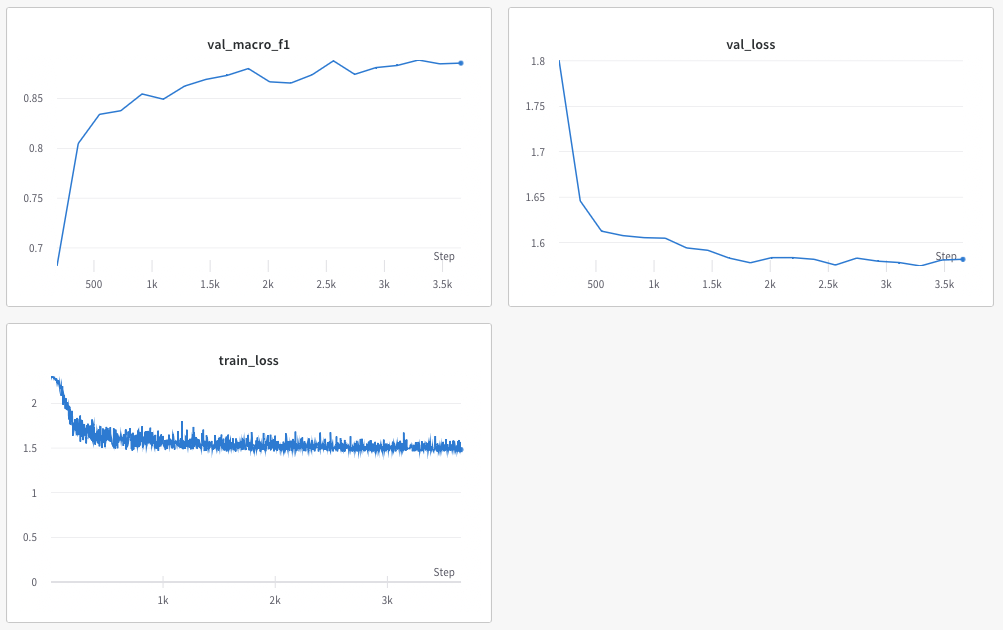


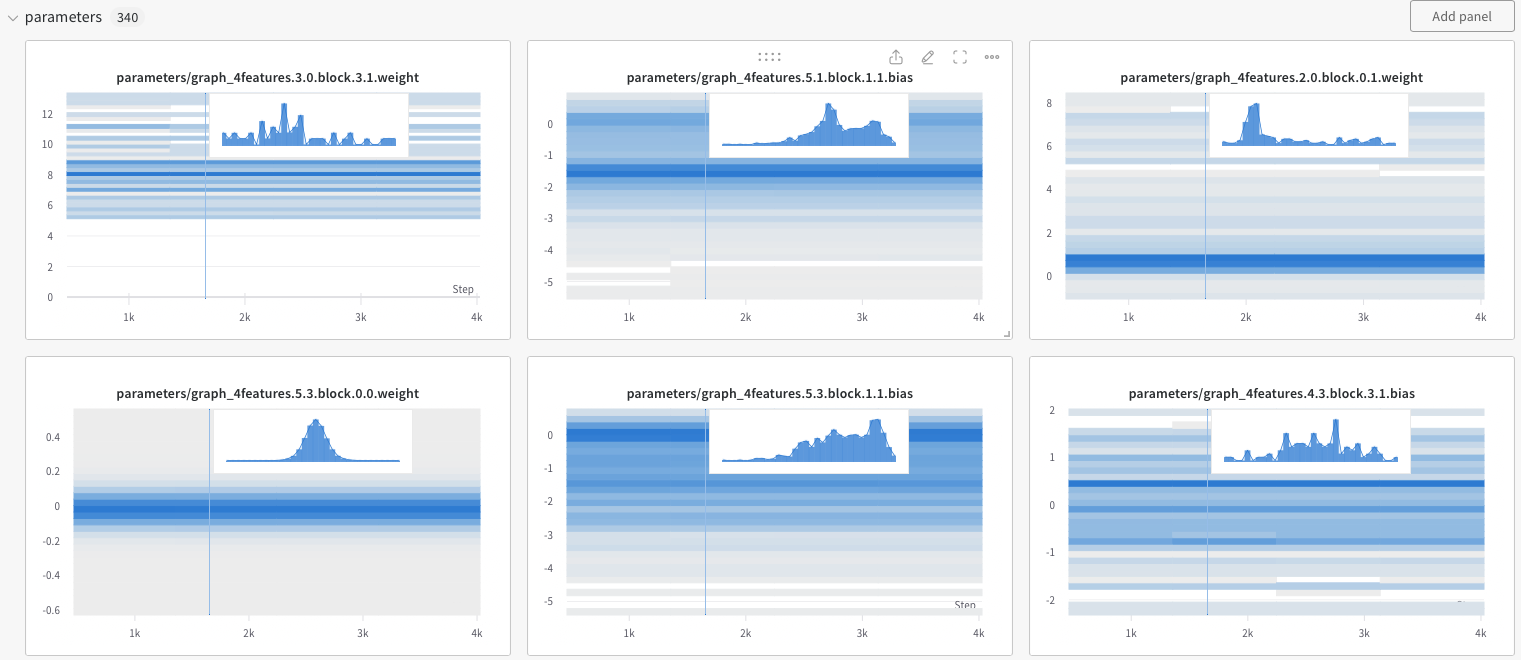

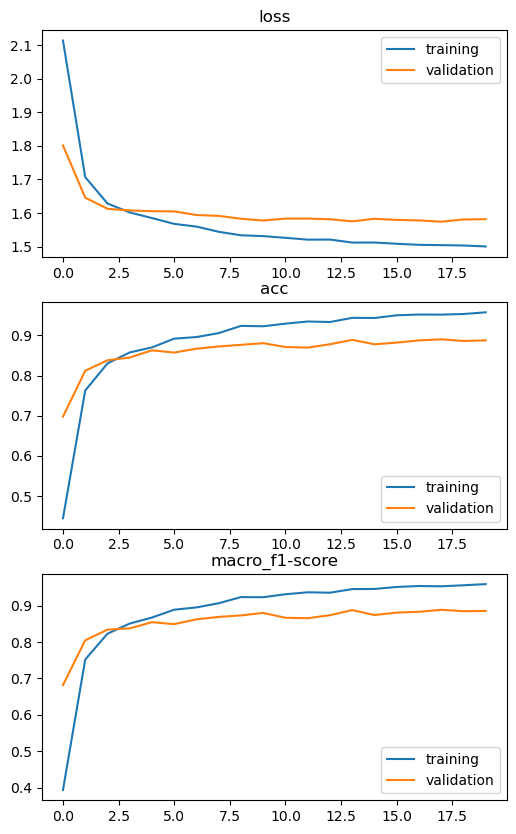

In [ ]:
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['macro_f1-score'], label = 'training')
axs[2].plot(history_val['macro_f1-score'], label = 'validation')
axs[2].set_title("macro_f1-score")
axs[2].legend()
plt.show()

In [ ]:
%%time
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
wandb.finish()

n_iter,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▃▄▃▃▂▂▂▂▃▁▂▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_macro_f1,▁▅▆▆▇▇▇▇▇█▇▇▇███████
n_iter,3639
train_loss,1.4673
val_loss,1.58161
val_macro_f1,0.8855


CPU times: user 151 ms, sys: 23.4 ms, total: 175 ms
Wall time: 7.56 s


# Testing on test set

In [ ]:
print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        model.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

testing ...


100%|██████████| 23/23 [00:40<00:00,  1.77s/it]

testing loss: 1.577
              precision    recall  f1-score   support

           0     0.7547    0.9091    0.8247        44
           1     0.9149    0.9149    0.9149        94
           2     0.9200    0.8582    0.8880       134
           3     0.7931    0.8734    0.8313        79
           4     0.9268    0.8571    0.8906       133
           5     0.9048    0.8444    0.8736        45
           6     0.8913    0.9535    0.9213        43
           7     0.9041    0.8919    0.8980        74
           8     0.9062    0.8286    0.8657        35
           9     0.8654    0.9783    0.9184        46

    accuracy                         0.8845       727
   macro avg     0.8781    0.8909    0.8827       727
weighted avg     0.8884    0.8845    0.8849       727



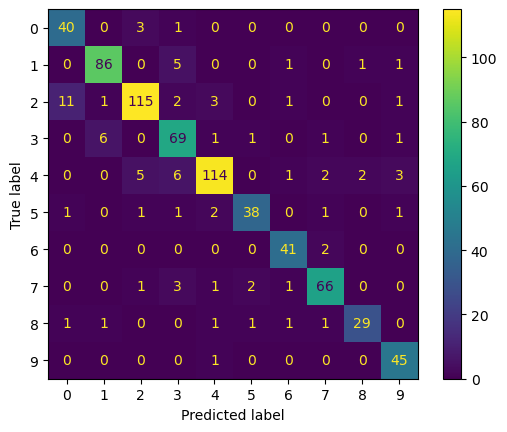

In [ ]:
disp.plot()
plt.show()

# Train model with all data in train folder

I submitted result of this part to Kaggle

In [ ]:
num_classes = 10
model_ft = torchvision.models.efficientnet_b3(weights=True)

model_ft.classifier[-1] = nn.Sequential(
    nn.Linear(in_features=model_ft.classifier[-1].in_features, out_features=num_classes),
    nn.Softmax(dim=1)
        )

model = model_ft.to(device)

In [ ]:
NUM_EPOCHS = 23
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [ ]:
from sklearn.metrics import classification_report
from tqdm import tqdm


all_history_train = {'loss':np.zeros(NUM_EPOCHS), 'acc':np.zeros(NUM_EPOCHS), 'macro_f1-score':np.zeros(NUM_EPOCHS)}
min_val_loss = 1e10
best_f1 = -1
PATH = './best_model.pth'
PATH_F1 = './best_model_f1.pth'

for epoch in range(NUM_EPOCHS):  
    
    print(f'epoch {epoch + 1} \nTraining ...')
    model.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for inputs, labels in tqdm(allloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
            n+=1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    support = report["macro avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%,  Macro f1-score: {f1*100:.4}%, support: {support}" )
    all_history_train['loss'][epoch] = training_loss
    all_history_train['acc'][epoch] = acc
    all_history_train['macro_f1-score'][epoch] = f1

    if training_loss < min_val_loss:
        torch.save(model.state_dict(), './best_model_train_all.pth')
        min_val_loss = training_loss
    
print('Finished Training')

epoch 1 
Training ...


100%|██████████| 228/228 [07:13<00:00,  1.90s/it]


training loss: 2.037, acc: 49.29%,  Macro f1-score: 44.64%, support: 7275
epoch 2 
Training ...


100%|██████████| 228/228 [06:01<00:00,  1.59s/it]


training loss: 1.683, acc: 78.5%,  Macro f1-score: 77.4%, support: 7275
epoch 3 
Training ...


100%|██████████| 228/228 [05:55<00:00,  1.56s/it]


training loss: 1.623, acc: 83.97%,  Macro f1-score: 83.08%, support: 7275
epoch 4 
Training ...


100%|██████████| 228/228 [05:56<00:00,  1.56s/it]


training loss: 1.602, acc: 85.73%,  Macro f1-score: 85.23%, support: 7275
epoch 5 
Training ...


100%|██████████| 228/228 [05:55<00:00,  1.56s/it]


training loss: 1.586, acc: 87.24%,  Macro f1-score: 86.94%, support: 7275
epoch 6 
Training ...


100%|██████████| 228/228 [06:00<00:00,  1.58s/it]


training loss: 1.57, acc: 88.44%,  Macro f1-score: 88.09%, support: 7275
epoch 7 
Training ...


100%|██████████| 228/228 [06:04<00:00,  1.60s/it]


training loss: 1.561, acc: 89.24%,  Macro f1-score: 89.09%, support: 7275
epoch 8 
Training ...


100%|██████████| 228/228 [06:02<00:00,  1.59s/it]


training loss: 1.545, acc: 90.8%,  Macro f1-score: 90.91%, support: 7275
epoch 9 
Training ...


100%|██████████| 228/228 [06:03<00:00,  1.59s/it]


training loss: 1.537, acc: 92.04%,  Macro f1-score: 92.22%, support: 7275
epoch 10 
Training ...


100%|██████████| 228/228 [06:05<00:00,  1.60s/it]


training loss: 1.535, acc: 92.0%,  Macro f1-score: 92.12%, support: 7275
epoch 11 
Training ...


100%|██████████| 228/228 [06:00<00:00,  1.58s/it]


training loss: 1.528, acc: 92.82%,  Macro f1-score: 93.09%, support: 7275
epoch 12 
Training ...


100%|██████████| 228/228 [06:00<00:00,  1.58s/it]


training loss: 1.525, acc: 93.03%,  Macro f1-score: 93.15%, support: 7275
epoch 13 
Training ...


100%|██████████| 228/228 [05:57<00:00,  1.57s/it]


training loss: 1.522, acc: 93.64%,  Macro f1-score: 93.74%, support: 7275
epoch 14 
Training ...


100%|██████████| 228/228 [05:58<00:00,  1.57s/it]


training loss: 1.519, acc: 93.64%,  Macro f1-score: 93.81%, support: 7275
epoch 15 
Training ...


100%|██████████| 228/228 [06:01<00:00,  1.58s/it]


training loss: 1.516, acc: 94.02%,  Macro f1-score: 94.19%, support: 7275
epoch 16 
Training ...


100%|██████████| 228/228 [05:57<00:00,  1.57s/it]


training loss: 1.512, acc: 94.34%,  Macro f1-score: 94.56%, support: 7275
epoch 17 
Training ...


100%|██████████| 228/228 [05:56<00:00,  1.56s/it]


training loss: 1.509, acc: 94.71%,  Macro f1-score: 94.92%, support: 7275
epoch 18 
Training ...


100%|██████████| 228/228 [06:01<00:00,  1.59s/it]


training loss: 1.508, acc: 94.75%,  Macro f1-score: 95.05%, support: 7275
epoch 19 
Training ...


100%|██████████| 228/228 [06:05<00:00,  1.60s/it]


training loss: 1.508, acc: 94.93%,  Macro f1-score: 95.13%, support: 7275
epoch 20 
Training ...


100%|██████████| 228/228 [06:02<00:00,  1.59s/it]


training loss: 1.51, acc: 94.83%,  Macro f1-score: 95.06%, support: 7275
epoch 21 
Training ...


100%|██████████| 228/228 [06:00<00:00,  1.58s/it]


training loss: 1.507, acc: 94.91%,  Macro f1-score: 95.16%, support: 7275
epoch 22 
Training ...


100%|██████████| 228/228 [05:57<00:00,  1.57s/it]


training loss: 1.505, acc: 95.09%,  Macro f1-score: 95.29%, support: 7275
epoch 23 
Training ...


100%|██████████| 228/228 [05:59<00:00,  1.58s/it]

training loss: 1.504, acc: 95.34%,  Macro f1-score: 95.5%, support: 7275
Finished Training


In [ ]:
model.load_state_dict(torch.load('/kaggle/working/best_model_train_all.pth'))

<All keys matched successfully>

# Submit to Kaggle

In [ ]:
import os
import pandas as pd
import argparse

path = '/kaggle/input/submittest/test'
def gen_filename():
    d={}
    images = os.listdir(path)
    sorted_filenames = sorted(images, key=lambda x: int(x.split("test")[1].split(".")[0]))
    for image in sorted_filenames:
        if image == '.DS_Store': continue
        d[image] = 0

    file = pd.DataFrame(d.keys(), columns=['ID'])
    file.to_csv('submission.csv', index=False)


gen_filename()


In [ ]:
submit = pd.read_csv('/kaggle/working/submission.csv')
submit


,ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg
...,...
4643,test4643.jpg
4644,test4644.jpg
4645,test4645.jpg
4646,test4646.jpg


In [ ]:
test_path = '/kaggle/input/submittest/test'
class TestDataset(Dataset):
    
    def __init__(self, 
                 img_dir, 
                 transforms=None):
        
        super().__init__()
        self.input_dataset = list()

        _, _, files = next(os.walk(os.path.join(img_dir)))
        for image_name in submit['ID']:
            input = [os.path.join(img_dir,image_name), image_name] 
            self.input_dataset.append(input)
        
        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx): 
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        return x, self.input_dataset[idx][1]

submitset = TestDataset(test_path,transform)
submitloader = torch.utils.data.DataLoader(submitset, batch_size=32, shuffle=False)

In [ ]:
print('running ...')
y_predict = list()
model.eval()
with torch.no_grad():
    for inputs, _ in tqdm(submitloader):

        inputs = inputs.to(device)
        outputs = model(inputs)
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
print('Finished')


running ...


100%|██████████| 146/146 [03:33<00:00,  1.46s/it]

Finished


In [ ]:
len(y_predict)

4648

In [ ]:
submit_df = pd.DataFrame()
submit_df['ID'] = list(range(len(y_predict)))
submit_df['class'] = y_predict
submit_df

,ID,class
0,0,4
1,1,4
2,2,1
3,3,4
4,4,1
...,...,...
4643,4643,9
4644,4644,7
4645,4645,5
4646,4646,7


In [ ]:
submit_df.to_csv('submission86.csv', index=False)
